In [9]:

import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [10]:
def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg


In [11]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)


In [12]:

''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(9, 9) (1, 9)
(9, 9) (1, 9)
Alphas for hard margins:  [[4.68647413e-13]
 [4.05837620e-14]
 [2.27663557e-13]
 [1.37333449e-13]
 [3.15649952e-14]
 [5.47992168e-14]
 [1.52582262e-13]
 [4.97336291e+00]
 [8.73287645e-14]
 [3.69044608e-14]
 [8.64159333e-14]
 [2.21627489e-13]
 [1.13642557e-13]
 [5.34711198e-14]
 [5.44295342e-14]
 [4.27632927e-14]
 [3.23524499e-13]
 [1.01724489e-12]
 [9.02416476e-14]
 [8.89297399e-13]
 [7.37203448e-14]
 [8.47017612e-14]
 [6.03016193e-14]
 [1.21271222e-13]
 [4.92395213e+01]
 [4.79148066e-14]
 [3.54966145e+01]
 [1.03946277e-13]
 [3.57104733e-14]
 [4.45434020e-14]
 [5.32041894e+01]
 [7.59194456e-14]
 [4.44132695e-14]
 [5.76179440e-14]
 [4.26116364e-14]
 [7.36734445e-14]
 [2.24584835e+00]
 [4.55442222e-14]
 [6.55132388e-14]
 [5.87250284e-14]
 [3.68937859e-14]
 [6.57674134e-14]
 [4.39768664e-14]
 [7.71988406e-14]
 [5.31416708e-14]
 [8.45551601e-14]
 [5.56914942e-14]
 [4.96123008e-14]
 [2.91397236e-13]
 [3.93873461e-14]
 [4.86254062e-14]
 [1.25095494e-13]
 [6.900623

In [13]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)


Alphas for soft margins:  [[1.96272501e-12]
 [1.37975506e-13]
 [5.77969695e-13]
 [4.41828303e-13]
 [1.11067778e-13]
 [1.84753189e-13]
 [4.65726943e-13]
 [4.97336290e+00]
 [3.15990775e-13]
 [1.25637397e-13]
 [2.91855500e-13]
 [8.01244811e-13]
 [3.62836026e-13]
 [1.78195871e-13]
 [1.81982764e-13]
 [1.46338440e-13]
 [9.41438617e-13]
 [3.63194097e-12]
 [3.03180402e-13]
 [2.47936385e-12]
 [2.67364922e-13]
 [2.88716694e-13]
 [2.02409355e-13]
 [3.97533919e-13]
 [4.92395213e+01]
 [1.59138665e-13]
 [3.54966145e+01]
 [3.65624434e-13]
 [1.22205312e-13]
 [1.50345292e-13]
 [5.32041894e+01]
 [2.62262301e-13]
 [1.49389267e-13]
 [1.95349759e-13]
 [1.40499699e-13]
 [2.44652392e-13]
 [2.24584835e+00]
 [1.50714396e-13]
 [2.22311003e-13]
 [1.95420449e-13]
 [1.30989283e-13]
 [2.33439885e-13]
 [1.49574043e-13]
 [2.37880686e-13]
 [1.83527552e-13]
 [3.05980309e-13]
 [1.93282255e-13]
 [1.61544791e-13]
 [9.77071829e-13]
 [1.33426683e-13]
 [1.62332593e-13]
 [4.46477704e-13]
 [2.39503505e-13]
 [2.60783211e-13]
 [

<a list of 3 text.Text objects>

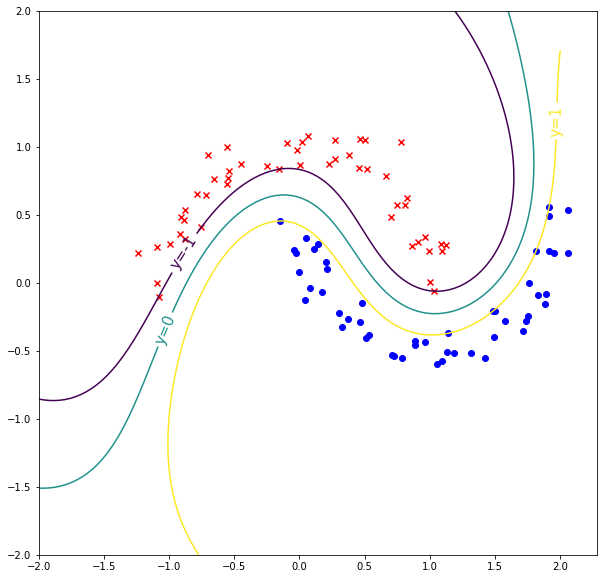

In [14]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)


<a list of 3 text.Text objects>

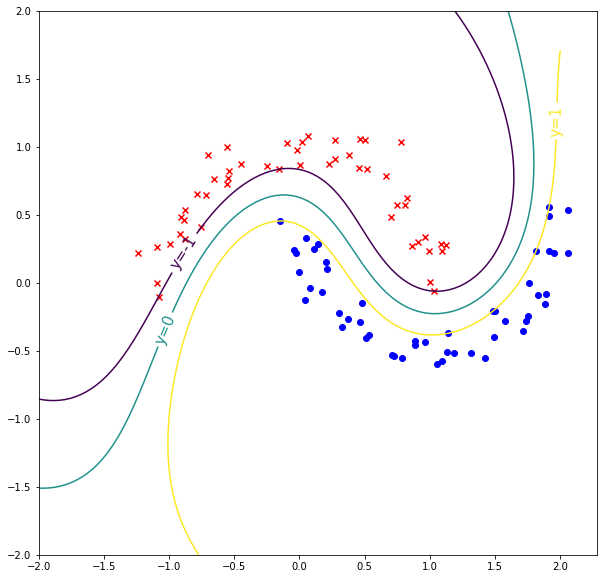

In [15]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)
